In [1]:
import sys
import os
import h5py
import mattplotlib

# setup paths
iteration = 1 # which version of this tutorial to run (in case want results in different dirs)
NBname = 'color_cloud_initial{}'.format(iteration)

myhost = os.uname()[1] # get name of machine
print("Running on Computer: [%s]" %myhost)

datadir = './Mdata/'
dirname = './Monocular/' # Working directory 

import numpy as np
import scipy.io as sio
import pickle
from copy import deepcopy

# plotting
import matplotlib.pyplot as plt
import mattplotlib as m
import mattrics as met

# Import torch
import torch
from torch import nn

# NDN tools
import NDNT.utils as utils # some other utilities
from NDNT.utils import imagesc   # because I'm lazy
from NDNT.utils import ss        # because I'm real lazy
import NDNT.NDNT as NDN
from NDNT.modules.layers import *
from NDNT.networks import *
from importlib import reload
from time import time
import dill # more comprehensive pickle

from NTdatasets.generic import GenericDataset
from NTdatasets.cumming.binocular import binocular_single

device = torch.device("cuda:1")
dtype = torch.float32

# Where saved models and checkpoints go -- this is to be automated
print( 'Save_dir =', dirname)

# Lazy stuff
from NDNT.utils.DanUtils import ss
from NDNT.utils.DanUtils import imagesc

%load_ext autoreload
%autoreload 2

Invoking __init__.py for NDNT.utils
Running on Computer: [beast]
Save_dir = ./Monocular/


Loading expt04
  Time embedding...
11 cells, 362504 time steps.


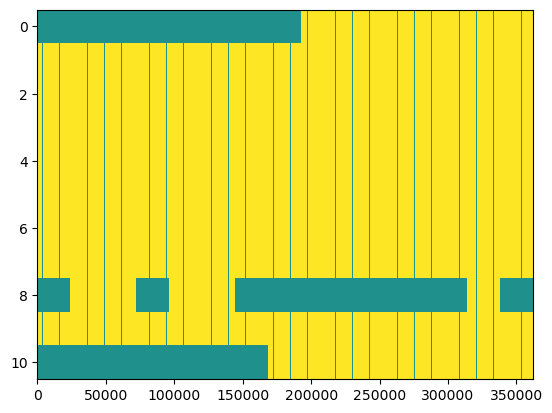

In [2]:
# Load Data
num_lags = 10
expts = ['expt04']
# this can handle multiple experiments
#expts = ['expt04', 'expt05']

from NTdatasets.cumming.monocular import MultiDataset
data = MultiDataset(
    datadir=datadir, filenames=expts, include_MUs=False,
    time_embed=True, num_lags=num_lags )
imagesc(data.dfs.detach().numpy())
print("%d cells, %d time steps."%(data.NC, data.NT))

## CNIM

Network 0:
  Layer 0:
      weight: torch.Size([210, 8])
  Layer 1:
      weight: torch.Size([288, 11])
      bias: torch.Size([11])


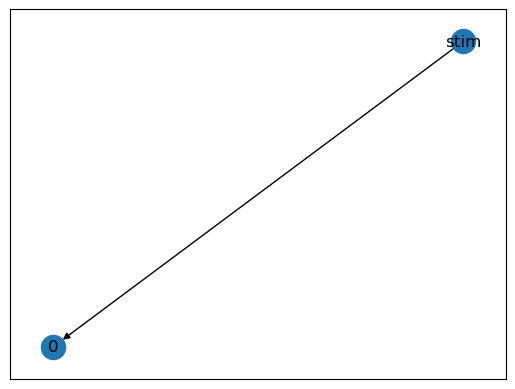

In [3]:
num_subs = 8
fw = 21
XTreg0 = 0.01
L1reg0 = 0.0001
Greg = 0.001
# subunit layer
csub_par = ConvLayer.layer_dict(
    input_dims=data.stim_dims,
    num_filters=num_subs,
    norm_type=1,
    num_inh=num_subs//2, # this specifies that the first half of the subunits should be inhibitory (use "flipped" ReLU nonlinearity)
    filter_dims=fw, # dimensions of the Convolutional filter
    window='hamming', # apply a Hamming window to the filters to avoid edge artifacts 
    NLtype='relu',
    bias=False,
    initialize_center = True)
csub_par['reg_vals'] = {'d2xt': XTreg0, 'l1':L1reg0, 'center':Greg, 'bcs':{'d2xt':1}  }

# 'readout' layer
readout_par = NDNLayer.layer_dict(
    num_filters=data.NC,
    norm_type=0,
    NLtype='softplus',
    bias=True, # b/c it is the last layer
    pos_constraint=True, # this removes negative values created from the inhibitory subunits from the output
    initialize_center = True)

readout_par['reg_vals'] = {'glocalx': Greg  }
cnim_all = NDN.NDN( layer_list=[csub_par, readout_par] )
cnim_all.list_parameters()

m.draw_model(cnim_all)

In [4]:
#cnim_all.fit(data, **adam_pars, verbose=2)
#LLs1 = cnim_all.eval_models(data[data.val_inds], null_adjusted=True)
#print(LLs1, np.mean(LLs1))
#
#import pickle
#with open('cnim1.pickle', 'wb') as f:
#    pickle.dump(cnim_all, f)

with open('cnim1.pickle', 'rb') as f:
    cnim_all = pickle.load(f)

In [5]:
cnim_all.list_parameters()

Network 0:
  Layer 0:
      weight: torch.Size([210, 8])
  Layer 1:
      weight: torch.Size([288, 11])
      bias: torch.Size([11])


### plot convolutional filters

In [6]:
cnim_all.networks[0].layers[0].get_weights().shape, cnim_all.networks[0].layers[1].get_weights().shape

((21, 10, 8), (8, 36, 11))

In [7]:
# https://theaisummer.com/receptive-field/
# https://distill.pub/2019/computing-receptive-fields/
# Article for how to calculate the receptive field of a CNN

# sum over the filters horizontally,
# so that we have 10 x 36 coming out of the first layer
# and 

# get the convolutional filters
hidden = cnim_all.networks[0].layers[0].get_weights()
output = cnim_all.networks[0].layers[1].get_weights()
data.stim_dims, '-->', hidden.shape, '-->', output.shape

([1, 36, 1, 10], '-->', (21, 10, 8), '-->', (8, 36, 11))

In [8]:
np.sum(output, axis=0).shape

(36, 11)

In [9]:
# hidden layer reshaped to be a list of 8 boxes
# (21, 10, 8) --> (8, 10, 21)
hidden_boxes = np.swapaxes(hidden, 0,2)
# means of the weights of each neuron
# (8, 38, 11) --> (36, 11) --> (1, 36, 11)
output_sums = np.expand_dims(np.sum(output, axis=0), 1)
output_sums = np.swapaxes(output_sums, 0,2)

print(output.shape, hidden_boxes.shape, output_sums.shape)

output[:,0,0][output[:,0,0]<0]

print(output.shape)

(8, 36, 11) (8, 10, 21) (11, 1, 36)
(8, 36, 11)


In [10]:
# cool plotting here to make sure it makes sense


# create weights
col_idx = 1680 # terrible hack
weights = {}
# create the edge dictionary per neuron
for c in range(output.shape[2]): # for each neuron
    for col in range(output.shape[1]): # for each column in the neuron
        i = 0 # start the id
        weights[col_idx] = {}
        print(col_idx)
        # normalize output
        max_weight = np.max(output[:,col,c])
        if max_weight == 0:
                max_weight = 1
        posnorm = output[:,col,c] / max_weight
        # there is no negative value b/c we put pos constraint, need to more automagically account for this
        #negnorm = np.where(output[:,col,c]<0, output[:,col,c], 0) / np.abs(np.min(output[:,col,c][output[:,col,c]<0]))
        output_normalized = posnorm
        #print(output_normalized.shape, np.min(output_normalized), np.max(output_normalized))
        for b, w in enumerate(output_normalized): # for each box & its weight
            for row in range(hidden_boxes[b,:,:].shape[0]): # for each row in the box
                for row in range(hidden_boxes[b,:,:].shape[1]): # for each col in that row
                    weights[col_idx][i] = w
                    i += 1
        col_idx += 1
                
print(weights.keys())
print(np.sum(hidden_boxes), np.sum(output_sums))

1680
1681
1682
1683
1684
1685
1686
1687
1688
1689
1690
1691
1692
1693
1694
1695
1696
1697
1698
1699
1700
1701
1702
1703
1704
1705
1706
1707
1708
1709
1710
1711
1712
1713
1714
1715
1716
1717
1718
1719
1720
1721
1722
1723
1724
1725
1726
1727
1728
1729
1730
1731
1732
1733
1734
1735
1736
1737
1738
1739
1740
1741
1742
1743
1744
1745
1746
1747
1748
1749
1750
1751
1752
1753
1754
1755
1756
1757
1758
1759
1760
1761
1762
1763
1764
1765
1766
1767
1768
1769
1770
1771
1772
1773
1774
1775
1776
1777
1778
1779
1780
1781
1782
1783
1784
1785
1786
1787
1788
1789
1790
1791
1792
1793
1794
1795
1796
1797
1798
1799
1800
1801
1802
1803
1804
1805
1806
1807
1808
1809
1810
1811
1812
1813
1814
1815
1816
1817
1818
1819
1820
1821
1822
1823
1824
1825
1826
1827
1828
1829
1830
1831
1832
1833
1834
1835
1836
1837
1838
1839
1840
1841
1842
1843
1844
1845
1846
1847
1848
1849
1850
1851
1852
1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879


In [23]:
# normalize the data we are giving the plot
# preserve dimensionality
# https://stackoverflow.com/questions/29046162/numpy-array-loss-of-dimension-when-masking
posnorm = np.where(hidden_boxes>=0, hidden_boxes, 0) / np.max(hidden_boxes[hidden_boxes>=0])
negnorm = np.where(hidden_boxes<0, hidden_boxes, 0) / np.abs(np.min(hidden_boxes[hidden_boxes<0]))
hidden_boxes_normalized = posnorm + negnorm

print(np.min(hidden_boxes_normalized), np.max(hidden_boxes_normalized))
print(hidden_boxes_normalized.shape, output_sums.shape)

-1.0 1.0
(8, 10, 21) (11, 1, 36)


In [34]:
from IPython.display import display, Javascript, HTML
import json

def draw_grids(data, edges, width, layer_heights, layer_dims, padding, layer_padding):
    display(Javascript("""
        (function(element){
            require(['grids'], function(grids) {
                grids(element.get(0), %s, %s, %d, %s, %s, %d, %d);
            });
        })(element);
    """ % (json.dumps(data), edges, width, layer_heights, layer_dims, padding, layer_padding)))

In [38]:
display(Javascript("require.config({paths: {d3: 'https://d3js.org/d3.v5.min'}});"))
display(Javascript(filename="grids.js"))
display(HTML(filename="grids.css.html"))
# the layers to display
layers = [hidden_boxes_normalized.tolist(), output_sums.tolist()]
draw_grids(layers,
           weights,
           width=800,
           layer_heights={0:200, 1:200},
           layer_dims={0:{'rows':2, 'cols':4}, 1:{'rows':4, 'cols':3}},
           padding=5,
           layer_padding=10)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## excitation/inhibition

(8, 36, 11)


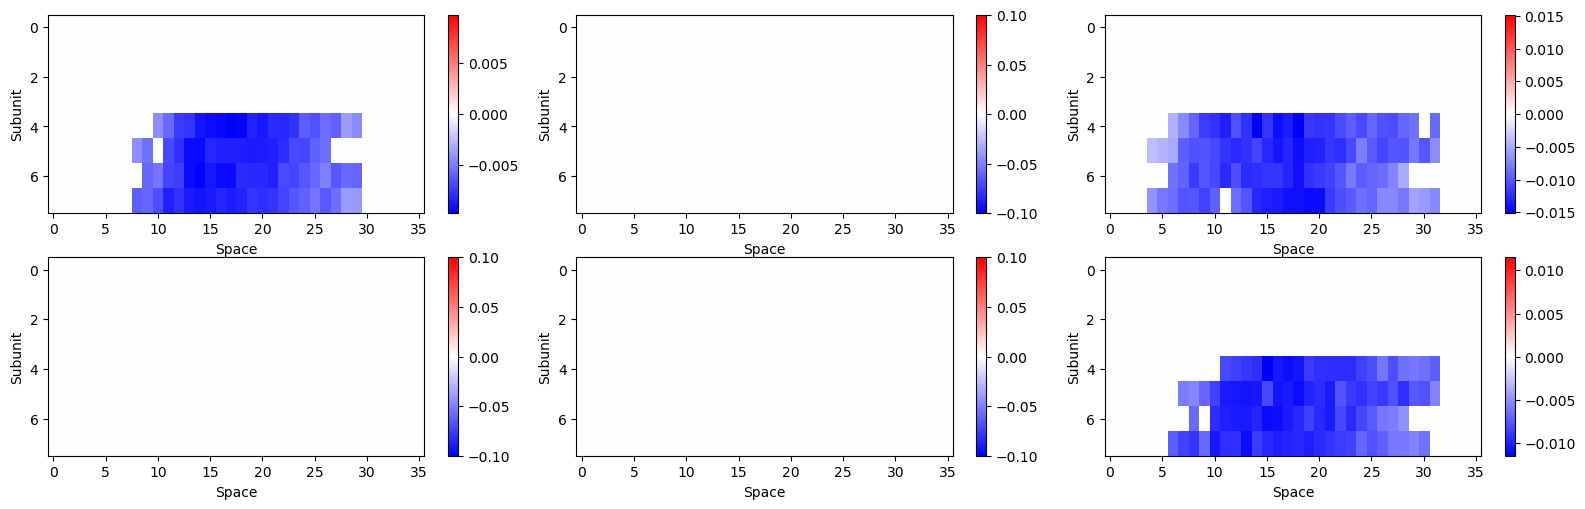

In [17]:
# Readout layer
wR = cnim_all.get_weights(layer_target=1)
print(wR.shape)
wR[num_subs//2:, :] *= -1 # Make inhibitory weights less than zero
num_col = np.minimum(data.NC, 6)
ss(2, num_col//2)
for cc in range(num_col):
    plt.subplot(2, num_col//2, cc+1)
    imagesc(wR[:,:,cc].T, cmap='bwr')
    plt.ylabel('Subunit')
    plt.xlabel('Space')
    plt.colorbar()
plt.show()